In [1]:
import findspark
findspark.init()

In [23]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName('Ex1').getOrCreate()

In [4]:
data = spark.read.csv('./data3D.csv',header=True,inferSchema=True)

In [5]:
data.show()

+-------+-------------------+-------------------+-------------------+
|     id|                  x|                  y|                  z|
+-------+-------------------+-------------------+-------------------+
| point0|  5.647627534046943| -6.356222340123802| -7.240816026826695|
| point1|  4.414367138680041| -10.32624175635328|  8.963324308916228|
| point2|  5.005396944639823| -9.301070062115645|  10.35473056351597|
| point3|  4.120163380083817| -7.602476887414266| 11.899997733558848|
| point4|  -9.90345298323414|  6.018967450867092| 2.0499450056095667|
| point5|-3.1594393958474907|  8.573317231663315|  2.358313545308847|
| point6| -7.397441928137873|  8.045395595903233| 1.7854606646015299|
| point7|-0.9693510271500931|  7.862982927569075| 3.2409227574252446|
| point8| 0.8429846570527002| -7.512538594618869| -7.011648822392197|
| point9|  5.790224308267301|-12.205503891046252|  8.483613639072914|
|point10| -9.446537710309725|  8.119076412296552|-0.4233730080356417|
|point11| -8.4183639

In [6]:
from pyspark.sql.functions import col, count, when, isnan, isnull

In [7]:
data = data.select('x','y','z')

In [8]:
data.show(3)

+-----------------+------------------+------------------+
|                x|                 y|                 z|
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328| 8.963324308916228|
|5.005396944639823|-9.301070062115645| 10.35473056351597|
+-----------------+------------------+------------------+
only showing top 3 rows



### Format from data

In [9]:
from pyspark.ml.feature import VectorAssembler

In [10]:
data.columns

['x', 'y', 'z']

In [11]:
vec_assembler = VectorAssembler(inputCols=data.columns,outputCol='features')

In [12]:
final_data = vec_assembler.transform(data)

### Scale the Data

In [13]:
from pyspark.ml.feature import StandardScaler

In [14]:
scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures',withStd=True, withMean=False)

In [15]:
scalerModel = scaler.fit(final_data)

In [16]:
final_data = scalerModel.transform(final_data)

In [17]:
final_data.show(3)

+-----------------+------------------+------------------+--------------------+--------------------+
|                x|                 y|                 z|            features|      scaledFeatures|
+-----------------+------------------+------------------+--------------------+--------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.64762753404694...|[1.01596735121698...|
|4.414367138680041|-10.32624175635328| 8.963324308916228|[4.41436713868004...|[0.79411272470554...|
|5.005396944639823|-9.301070062115645| 10.35473056351597|[5.00539694463982...|[0.90043471262547...|
+-----------------+------------------+------------------+--------------------+--------------------+
only showing top 3 rows



### Train model and evaluate

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [21]:
k_list = []
silhouette_list = []
for k in range(2,9):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    prediction = model.transform(final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(prediction)
    k_list.append(k)
    silhouette_list.append(silhouette)

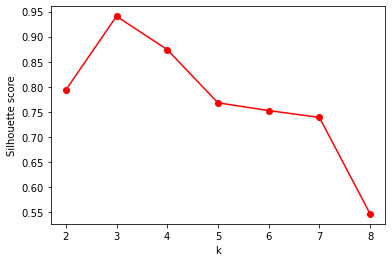

In [24]:
plt.plot(k_list, silhouette_list, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

### Select k = 5

In [25]:
kmeans = KMeans(featuresCol='scaledFeatures',k=5)
model = kmeans.fit(final_data)
prediction = model.transform(final_data)

In [26]:
center = model.clusterCenters()
center

[array([ 0.34289558, -0.88144134, -1.07461186]),
 array([-1.02101442,  1.04544395,  0.51977629]),
 array([ 0.74896823, -1.2269015 ,  1.46702482]),
 array([ 1.3263998 , -0.73359119, -0.99256846]),
 array([ 1.02299279, -0.74484447, -0.99846852])]

In [27]:
prediction.groupby('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|400000|
|         3|109912|
|         4| 95500|
|         2|200000|
|         0|194588|
+----------+------+



In [29]:
data_result = prediction.select('prediction')

In [37]:
type(data_result)

pyspark.sql.dataframe.DataFrame

In [38]:
final_data.show(3)

+-----------------+------------------+------------------+--------------------+--------------------+
|                x|                 y|                 z|            features|      scaledFeatures|
+-----------------+------------------+------------------+--------------------+--------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.64762753404694...|[1.01596735121698...|
|4.414367138680041|-10.32624175635328| 8.963324308916228|[4.41436713868004...|[0.79411272470554...|
|5.005396944639823|-9.301070062115645| 10.35473056351597|[5.00539694463982...|[0.90043471262547...|
+-----------------+------------------+------------------+--------------------+--------------------+
only showing top 3 rows



In [41]:
temp = final_data.select('scaledFeatures').rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [42]:
temp.show()

+--------------------+-------------------+--------------------+
|                  _1|                 _2|                  _3|
+--------------------+-------------------+--------------------+
|   1.015967351216984|-0.8133579916042446| -1.1300631023636798|
|  0.7941127247055418|-1.3213715327025208|  1.3988923401033808|
|  0.9004347126254798|-1.1901880174546255|  1.6160469899240184|
|   0.741187596138343|-0.9728318176240068|  1.8572144779101338|
| -1.7815595725145947| 0.7702020186526743|  0.3199317872642207|
| -0.5683602990775919| 1.0970629584357676|   0.368058394452257|
|  -1.330746306516117| 1.0295087952222317|   0.278654119965561|
|-0.17437923969243066|  1.006166817295677|  0.5058058666603217|
|  0.1516468435602876|-0.9613230903828899| -1.0942973266494809|
|  1.0416194796768314|-1.5618465812109734|  1.3240246282610082|
| -1.6993638192066636| 1.0389371754195587|-0.06607517897778672|
| -1.5144027905050126| 0.8227615695829846| 0.19548875508132596|
| -0.3752296527733015|   1.0768466987088

In [43]:
import pyspark.sql.functions as f

In [44]:
temp=temp.withColumn('row_index',f.monotonically_increasing_id())
data_result=data_result.withColumn('row_index',f.monotonically_increasing_id())
temp = temp.join(data_result,on=['row_index']).sort('row_index').drop('row_index')

In [45]:
temp = temp.select(col('_1').alias('x_scale'),
                  col('_2').alias('y_scale'),
                  col('_3').alias('z_scale'),'prediction')

In [46]:
df = temp.toPandas()

In [47]:
df.head()

,x_scale,y_scale,z_scale,prediction
0,1.015967,-0.813358,-1.130063,4
1,0.794113,-1.321372,1.398892,2
2,0.900435,-1.190188,1.616047,2
3,0.741188,-0.972832,1.857214,2
4,-1.781560,0.770202,0.319932,1


In [54]:
centers = model.clusterCenters()

In [57]:
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1,2
0,0.342896,-0.881441,-1.074612
1,-1.021014,1.045444,0.519776
2,0.748968,-1.226902,1.467025
3,1.326400,-0.733591,-0.992568
4,1.022993,-0.744844,-0.998469


In [49]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

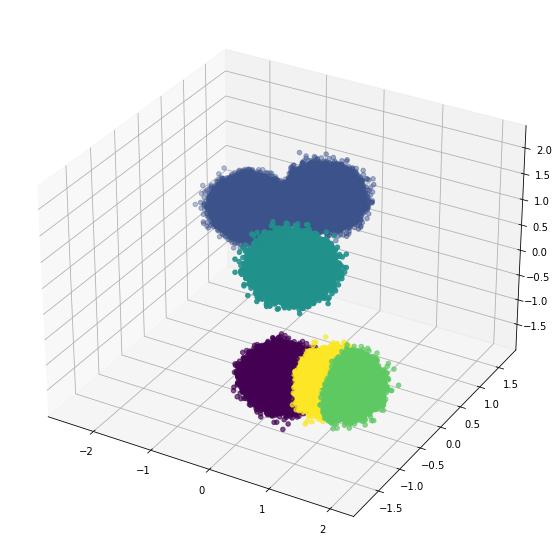

In [59]:
threedee = plt.figure(figsize =(12,10)).gca(projection='3d')
threedee.scatter(df.x_scale,df.y_scale,df.z_scale,c=df.prediction);

In [60]:
final_data = final_data.withColumn('row_index',f.monotonically_increasing_id())

In [61]:
temp = temp.withColumn('row_index',f.monotonically_increasing_id())

In [62]:
final_data = final_data.join(temp,on='row_index').sort('row_index').drop('row_index')

In [63]:
final_data.show()

+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+
|                  x|                  y|                  z|            features|      scaledFeatures|             x_scale|            y_scale|             z_scale|prediction|
+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+
|  5.647627534046943| -6.356222340123802| -7.240816026826695|[5.64762753404694...|[1.01596735121698...|   1.015967351216984|-0.8133579916042446| -1.1300631023636798|         4|
|  4.414367138680041| -10.32624175635328|  8.963324308916228|[4.41436713868004...|[0.79411272470554...|  0.7941127247055418|-1.3213715327025208|  1.3988923401033808|         2|
|  5.005396944639823| -9.301070062115645|  10.35473056351597|[5.00539694463982...|[0.90043471262547...|  0.90043471